In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('./../data/ece271b_data_select.mat')

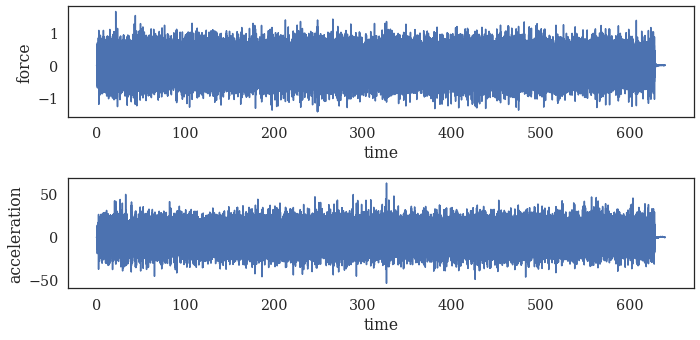

In [3]:
u = np.array(data['u'])
y = np.array(data['y'])
t = np.array(data['time'])[:,0]
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

1310


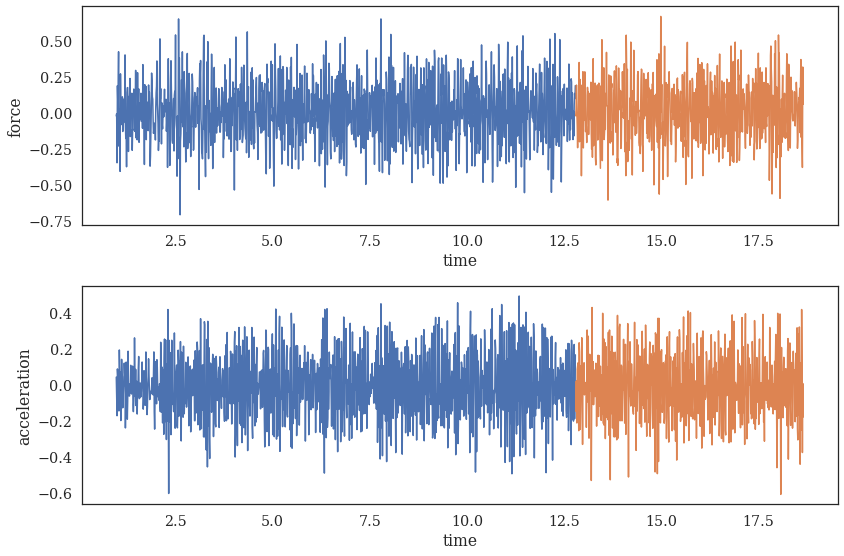

In [462]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.02)
start = 100

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:start+ntrain+500]
ytest = y_norm[ntrain:start+ntrain+500]
ttest = t[ntrain:start+ntrain+500]
intest = np.hstack([utest,ytest])

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [463]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy])
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [464]:
train_window = 16

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

torch.Size([1193, 2, 16]) torch.Size([1193, 1])


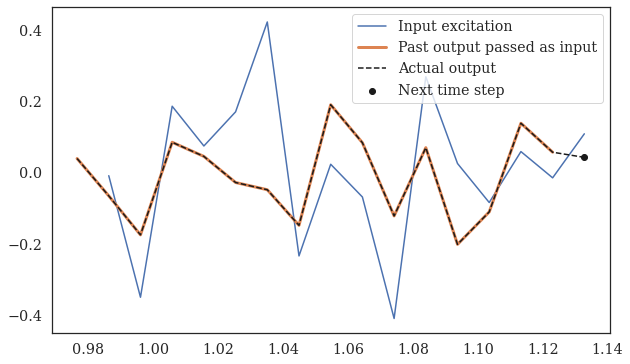

In [465]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,0,:])
plt.plot(ttrain[:train_window], x_train[0,1,:], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.show()

In [370]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [466]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, seq_len, dropout):
        super(TCN, self).__init__()
        self.seq_len = seq_len
        self.num_channels = num_channels
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1]*seq_len, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x).transpose(1, 2).reshape((-1, self.seq_len*self.num_channels[-1]))
        output = self.linear(output).double()
        return output

In [467]:
model = TCN(input_size = 2, 
            output_size = 1, 
            num_channels = [6]*6, 
            kernel_size = 3, 
            seq_len = train_window, 
            dropout = 0.1)

In [468]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction = "sum")

def train(model,epoch, X_train, Y_train, batch_size):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)

        loss = F.mse_loss(output, y.double())

        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 25 == 0:
            cur_loss = total_loss / 25
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate(model, X_test, Y_test):
    #model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [ ]:
epochs = 50000
batch_size = 250

for ep in range(1, epochs+1):
    train(model, ep, x_train, y_train, batch_size)
    print('Epoch: {}'.format(ep))
    tloss = evaluate(model, x_val, y_val)


Epoch: 1

Test set: Average loss: 0.043456

Epoch: 2

Test set: Average loss: 0.037107

Epoch: 3

Test set: Average loss: 0.038554

Epoch: 4

Test set: Average loss: 0.038999

Epoch: 5

Test set: Average loss: 0.038006

Epoch: 6

Test set: Average loss: 0.038595

Epoch: 7

Test set: Average loss: 0.038348

Epoch: 8

Test set: Average loss: 0.036522

Epoch: 9

Test set: Average loss: 0.037738

Epoch: 10

Test set: Average loss: 0.037704

Epoch: 11

Test set: Average loss: 0.038156

Epoch: 12

Test set: Average loss: 0.038289

Epoch: 13

Test set: Average loss: 0.037136

Epoch: 14

Test set: Average loss: 0.037176

Epoch: 15

Test set: Average loss: 0.037834

Epoch: 16

Test set: Average loss: 0.037240

Epoch: 17

Test set: Average loss: 0.037996

Epoch: 18

Test set: Average loss: 0.037869

Epoch: 19

Test set: Average loss: 0.037467

Epoch: 20

Test set: Average loss: 0.037157

Epoch: 21

Test set: Average loss: 0.037923

Epoch: 22

Test set: Average loss: 0.036493

Epoch: 23

Test set

Epoch: 182

Test set: Average loss: 0.032048

Epoch: 183

Test set: Average loss: 0.031077

Epoch: 184

Test set: Average loss: 0.032271

Epoch: 185

Test set: Average loss: 0.031783

Epoch: 186

Test set: Average loss: 0.031940

Epoch: 187

Test set: Average loss: 0.031553

Epoch: 188

Test set: Average loss: 0.031207

Epoch: 189

Test set: Average loss: 0.030594

Epoch: 190

Test set: Average loss: 0.030603

Epoch: 191

Test set: Average loss: 0.030764

Epoch: 192

Test set: Average loss: 0.030853

Epoch: 193

Test set: Average loss: 0.030695

Epoch: 194

Test set: Average loss: 0.030929

Epoch: 195

Test set: Average loss: 0.030829

Epoch: 196

Test set: Average loss: 0.031060

Epoch: 197

Test set: Average loss: 0.030642

Epoch: 198

Test set: Average loss: 0.030329

Epoch: 199

Test set: Average loss: 0.029707

Epoch: 200

Test set: Average loss: 0.029850

Epoch: 201

Test set: Average loss: 0.030519

Epoch: 202

Test set: Average loss: 0.030813

Epoch: 203

Test set: Average loss

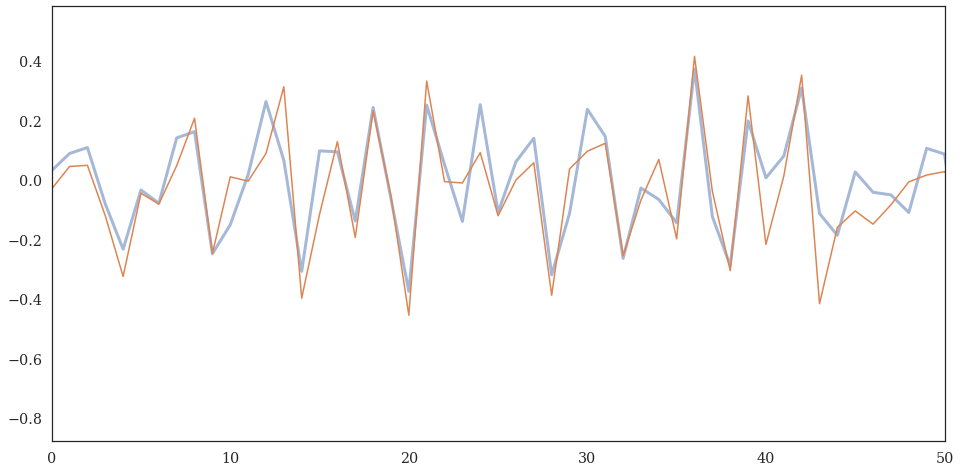

In [452]:
ypred = model(x_val)

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred.detach().numpy())

plt.xlim([0,50])
plt.show()

In [453]:

def simulate(x0, u, future):
    tw = x0.shape[-1]
    feats = x0.shape[0]

    x_ = x0.reshape((1,feats,tw))
    x = x0
    ypred = model(x_)
    
    for ii in range(1,future):
        new_pair = np.array([u[tw + ii][0], ypred.detach().numpy()[0][0]]).reshape((2,-1))
        x = np.concatenate([x, new_pair], axis = -1)
        
        x_ = x[:, -tw:].reshape((1, feats, tw))
        x_ = torch.from_numpy(x_)
        ypred = model(x_.float())
        
    return x

In [454]:
x0 = x_val[0]
ypred_sim = simulate(x0, utest, 250)
ypred_sim = ypred_sim[-1,train_window:]

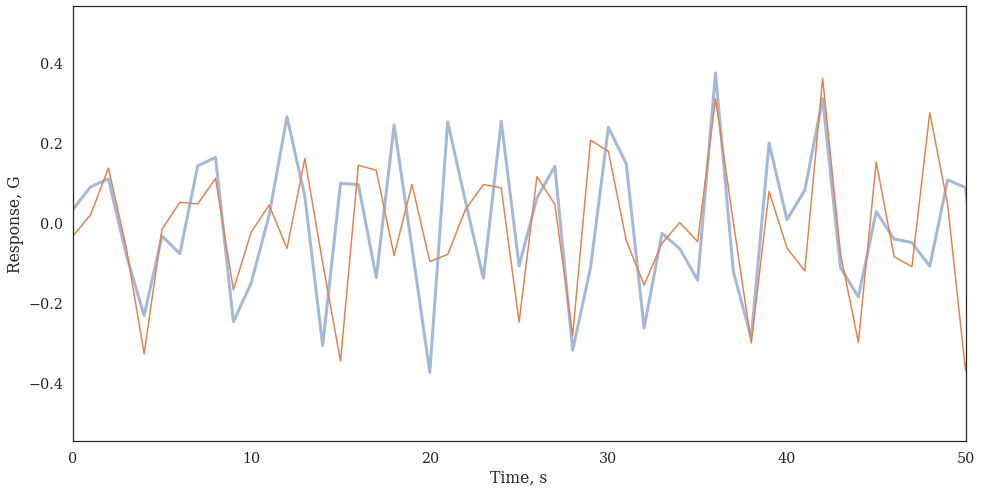

In [455]:

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred_sim.T)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

plt.xlim([0,50])
plt.show()

In [411]:
nchannels = [3, 6, 9]
nlayers = [3, 5, 7]
kernelsize = [3]

epochs = 3000
batch_size = 250

hyperparams = []

for nc in nchannels:
    for nl in nlayers:
        for ks in kernelsize:
            model = TCN(input_size = 2, 
                        output_size = 1, 
                        num_channels = [nc]*nl, 
                        kernel_size = ks, 
                        seq_len = train_window, 
                        dropout = 0.1)
            print([nc]*nl)
            for ep in range(1, epochs+1):
                train(model, ep, x_train, y_train, batch_size)
                if ep % 50 == 0:
                    print('Epoch: {}'.format(ep))
                    tloss = evaluate(model, x_val, y_val)
            
            hyperparams.append([nc, nl, ks, tloss])
            print(hyperparams[-1])


[3, 3, 3]
Epoch: 50

Test set: Average loss: 0.134593

Epoch: 100

Test set: Average loss: 0.132389

Epoch: 150

Test set: Average loss: 0.133284

Epoch: 200

Test set: Average loss: 0.134322

Epoch: 250

Test set: Average loss: 0.135027

Epoch: 300

Test set: Average loss: 0.135050

Epoch: 350

Test set: Average loss: 0.134070

Epoch: 400

Test set: Average loss: 0.134417

Epoch: 450

Test set: Average loss: 0.133154

Epoch: 500

Test set: Average loss: 0.135238

Epoch: 550

Test set: Average loss: 0.133870

Epoch: 600

Test set: Average loss: 0.134083

Epoch: 650

Test set: Average loss: 0.135453

Epoch: 700

Test set: Average loss: 0.133689

Epoch: 750

Test set: Average loss: 0.133335

Epoch: 800

Test set: Average loss: 0.134158

Epoch: 850

Test set: Average loss: 0.135802

Epoch: 900

Test set: Average loss: 0.134585

Epoch: 950

Test set: Average loss: 0.134795

Epoch: 1000

Test set: Average loss: 0.135263

Epoch: 1050

Test set: Average loss: 0.134038

Epoch: 1100

Test set: 

KeyboardInterrupt: 

In [322]:
ypred_sim[0:5]

array([ 0.41989222, -0.23836353, -0.18618323,  0.08892699, -0.13841254])

In [218]:
utest

array([[-0.09840609],
       [-0.36290135],
       [-0.09563409],
       [-0.06006006],
       [ 0.14368214],
       [ 0.34326634],
       [ 0.3113883 ],
       [ 0.09078308],
       [-0.01478401],
       [-0.27604527],
       [-0.32224531],
       [ 0.03465004],
       [ 0.07576808],
       [ 0.25086623],
       [-0.04920304],
       [-0.16585816],
       [ 0.02587203],
       [-0.19404018],
       [ 0.12658812],
       [ 0.13675213],
       [-0.27165625],
       [ 0.03765303],
       [ 0.23123121],
       [-0.16516516],
       [ 0.05959805],
       [-0.03811504],
       [-0.23608222],
       [ 0.25617924],
       [-0.09563409],
       [ 0.07900207],
       [-0.01293601],
       [-0.2196812 ],
       [ 0.28782624],
       [-0.35042732],
       [ 0.20997919],
       [ 0.48048047],
       [-0.00462   ],
       [ 0.27119425],
       [-0.32363131],
       [-0.26634325],
       [-0.06144606],
       [ 0.25386923],
       [ 0.33310232],
       [-0.2079002 ],
       [-0.07276507],
       [-0